# Programming Assignment

## Data pipeline with Keras and tf.data

### Instructions

In this notebook, you will implement a data processing pipeline using tools from both Keras and the tf.data module. You will use the `ImageDataGenerator` class in the tf.keras module to feed a network with training and test images from a local directory containing a subset of the LSUN dataset, and train the model both with and without data augmentation. You will then use the `map` and `filter` functions of the `Dataset` class with the CIFAR-100 dataset to train a network to classify a processed subset of the images.

Some code cells are provided you in the notebook. You should avoid editing provided code, and make sure to execute the cells in order to avoid unexpected errors. Some cells begin with the line:

`#### GRADED CELL ####`

Don't move or edit this first line - this is what the automatic grader looks for to recognise graded cells. These cells require you to write your own code to complete them, and are automatically graded when you submit the notebook. Don't edit the function name or signature provided in these cells, otherwise the automatic grader might not function properly. Inside these graded cells, you can use any functions or classes that are imported below, but make sure you don't use any variables that are outside the scope of the function.

### How to submit

Complete all the tasks you are asked for in the worksheet. When you have finished and are happy with your code, press the **Submit Assignment** button at the top of this notebook.

### Let's get started!

We'll start running some imports, and loading the dataset. Do not edit the existing imports in the following cell. If you would like to make further Tensorflow imports, you should add them here.

In [15]:
#### PACKAGE IMPORTS ####

# Run this cell first to import all required packages. Do not make any imports elsewhere in the notebook

import tensorflow as tf
from tensorflow.keras.datasets import cifar100
import numpy as np
import matplotlib.pyplot as plt
import json
%matplotlib inline

# If you would like to make further imports from tensorflow, add them here
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Input, MaxPooling2D


### Part 1: tf.keras
<table><tr>
<td> <img src="data/lsun/church.png" alt="Church" style="height: 210px;"/>  </td>
<td> <img src="data/lsun/classroom.png" alt="Classroom" style="height: 210px;"/> </td>
    <td> <img src="data/lsun/conference_room.png" alt="Conference Room" style="height: 210px;"/> </td>
</tr></table>
  
#### The LSUN Dataset

In the first part of this assignment, you will use a subset of the [LSUN dataset](https://www.yf.io/p/lsun). This is a large-scale image dataset with 10 scene and 20 object categories. A subset of the LSUN dataset has been provided, and has already been split into training and test sets. The three classes included in the subset are `church_outdoor`, `classroom` and `conference_room`.

* F. Yu, A. Seff, Y. Zhang, S. Song, T. Funkhouser and J. Xia. "LSUN: Construction of a Large-scale Image Dataset using Deep Learning with Humans in the Loop". arXiv:1506.03365, 10 Jun 2015 

Your goal is to use the Keras preprocessing tools to construct a data ingestion and augmentation pipeline to train a neural network to classify the images into the three classes.

In [2]:
# Save the directory locations for the training, validation and test sets

train_dir = 'data/lsun/train'
valid_dir = 'data/lsun/valid'
test_dir = 'data/lsun/test'

#### Create a data generator using the ImageDataGenerator class

You should first write a function that creates an `ImageDataGenerator` object, which rescales the image pixel values by a factor of 1/255.

In [6]:
#### GRADED CELL ####

# Complete the following function. 
# Make sure to not change the function name or arguments.

def get_ImageDataGenerator():
    """
    This function should return an instance of the ImageDataGenerator class.
    This instance should be set up to rescale the data with the above scaling factor.
    """
    return ImageDataGenerator(rescale=1/255.)
    
    

In [7]:
# Call the function to get an ImageDataGenerator as specified

image_gen = get_ImageDataGenerator()

You should now write a function that returns a generator object that will yield batches of images and labels from the training and test set directories. The generators should:

* Generate batches of size 20.
* Resize the images to 64 x 64 x 3.
* Return one-hot vectors for labels. These should be encoded as follows:
    * `classroom` $\rightarrow$ `[1., 0., 0.]`
    * `conference_room` $\rightarrow$ `[0., 1., 0.]`
    * `church_outdoor` $\rightarrow$ `[0., 0., 1.]`
* Pass in an optional random `seed` for shuffling (this should be passed into the `flow_from_directory` method).

**Hint:** you may need to refer to the [documentation](https://keras.io/preprocessing/image/#imagedatagenerator-class) for the `ImageDataGenerator`.

In [8]:
#### GRADED CELL ####

# Complete the following function.
# Make sure not to change the function name or arguments.

def get_generator(image_data_generator, directory, seed=None):
    """
    This function takes an ImageDataGenerator object in the first argument and a 
    directory path in the second argument.
    It should use the ImageDataGenerator to return a generator object according 
    to the above specifications. 
    The seed argument should be passed to the flow_from_directory method.
    """
    return image_data_generator.flow_from_directory(directory,
                                                   batch_size=20,
                                                   target_size=(64, 64),
                                                   classes=['classroom', 'conference_room', 'church_outdoor'],
                                                   seed=seed)
    

In [9]:
# Run this cell to define training and validation generators

train_generator = get_generator(image_gen, train_dir)
valid_generator = get_generator(image_gen, valid_dir)

Found 300 images belonging to 3 classes.
Found 120 images belonging to 3 classes.


We are using a small subset of the dataset for demonstrative purposes in this assignment.

#### Display sample images and labels from the training set

The following cell depends on your function `get_generator` to be implemented correctly. If it raises an error, go back and check the function specifications carefully.

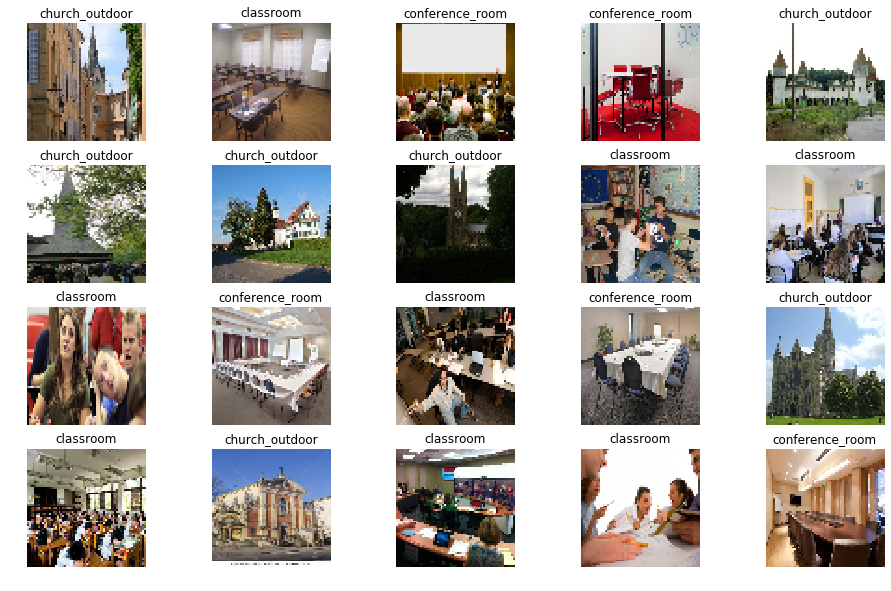

In [10]:
# Display a few images and labels from the training set

batch = next(train_generator)
batch_images = np.array(batch[0])
batch_labels = np.array(batch[1])
lsun_classes = ['classroom', 'conference_room', 'church_outdoor']

plt.figure(figsize=(16,10))
for i in range(20):
    ax = plt.subplot(4, 5, i+1)
    plt.imshow(batch_images[i])
    plt.title(lsun_classes[np.where(batch_labels[i] == 1.)[0][0]])
    plt.axis('off')

In [11]:
# Reset the training generator

train_generator = get_generator(image_gen, train_dir)

Found 300 images belonging to 3 classes.


#### Build the neural network model

You will now build and compile a convolutional neural network classifier. Using the functional API, build your model according to the following specifications:

* The model should use the `input_shape` in the function argument to define the Input layer.
* The first hidden layer should be a Conv2D layer with 8 filters, a 8x8 kernel size.
* The second hidden layer should be a MaxPooling2D layer with a 2x2 pooling window size.
* The third hidden layer should be a Conv2D layer with 4 filters, a 4x4 kernel size.
* The fourth hidden layer should be a MaxPooling2D layer with a 2x2 pooling window size.
* This should be followed by a Flatten layer, and then a Dense layer with 16 units and ReLU activation.
* The final layer should be a Dense layer with 3 units and softmax activation.
* All Conv2D layers should use `"SAME"` padding and a ReLU activation function.

In total, the network should have 8 layers. The model should then be compiled with the Adam optimizer with learning rate 0.0005, categorical cross entropy loss, and the 'accuracy' metric.

In [16]:
#### GRADED CELL ####

# Complete the following function.
# Make sure not to change the function name or arguments.

def get_model(input_shape):
    """
    This function should build and compile a CNN model according to the above specification,
    using the functional API. Your function should return the model.
    """
    conv2D_config = {'activation':'relu', 'padding':'SAME'}
    inp = Input(input_shape)
    h = Conv2D(8, (8, 8), **conv2D_config)(inp)
    h = MaxPooling2D((2, 2))(h)
    h = Conv2D(4, (4, 4), **conv2D_config)(h)
    h = MaxPooling2D((2, 2))(h)
    h = Flatten()(h)
    h = Dense(16, activation='relu')(h)
    h = Dense(3, activation='softmax')(h)
    
    model = Model(inputs=inp, outputs=h)

    opt = tf.keras.optimizers.Adam(0.0005)
    loss = 'categorical_crossentropy'
    metrics = ['accuracy']
    model.compile(optimizer=opt, loss=loss, metrics=metrics)

    return model
    

In [17]:
# Build and compile the model, print the model summary

lsun_model = get_model((64, 64, 3))
lsun_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 8)         1544      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 4)         516       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 4)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 16)                16400 

#### Train the neural network model

You should now write a function to train the model for a specified number of epochs (specified in the `epochs` argument). The function takes a `model` argument, as well as `train_gen` and `valid_gen` arguments for the training and validation generators respectively, which you should use for training and validation data in the training run. You should also use the following callbacks:

* An `EarlyStopping` callback that monitors the validation accuracy and has patience set to 10. 
* A `ReduceLROnPlateau` callback that monitors the validation loss and has the factor set to 0.5 and minimum learning set to 0.0001

Your function should return the training history.

In [18]:
#### GRADED CELL ####

# Complete the following function.
# Make sure not to change the function name or arguments.

def train_model(model, train_gen, valid_gen, epochs):
    """
    This function should define the callback objects specified above, and then use the
    train_gen and valid_gen generator object arguments to train the model for the (maximum) 
    number of epochs specified in the function argument, using the defined callbacks.
    The function should return the training history.
    """
    earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)
    lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, min_lr=0.0001)
    
    return model.fit(train_gen,
                    epochs=epochs,
                    callbacks=[earlystopping, lr_callback],
                    validation_data=valid_gen)
    

In [19]:
# Train the model for (maximum) 50 epochs

history = train_model(lsun_model, train_generator, valid_generator, epochs=50)

Train for 15 steps, validate for 6 steps
Epoch 1/50
15/15 [==============================] - 12s 776ms/step - loss: 1.1101 - accuracy: 0.3233 - val_loss: 1.0767 - val_accuracy: 0.4667
Epoch 2/50
15/15 [==============================] - 9s 600ms/step - loss: 1.0595 - accuracy: 0.4367 - val_loss: 1.0459 - val_accuracy: 0.4417
Epoch 3/50
15/15 [==============================] - 9s 613ms/step - loss: 1.0106 - accuracy: 0.4667 - val_loss: 0.9720 - val_accuracy: 0.5583
Epoch 4/50
15/15 [==============================] - 9s 593ms/step - loss: 0.9221 - accuracy: 0.5833 - val_loss: 0.8560 - val_accuracy: 0.6500
Epoch 5/50
15/15 [==============================] - 9s 607ms/step - loss: 0.8293 - accuracy: 0.6433 - val_loss: 0.8642 - val_accuracy: 0.5833
Epoch 6/50
15/15 [==============================] - 9s 600ms/step - loss: 0.8225 - accuracy: 0.6333 - val_loss: 0.8635 - val_accuracy: 0.6083
Epoch 7/50
15/15 [==============================] - 9s 606ms/step - loss: 0.7307 - accuracy: 0.7167 - val_

#### Plot the learning curves

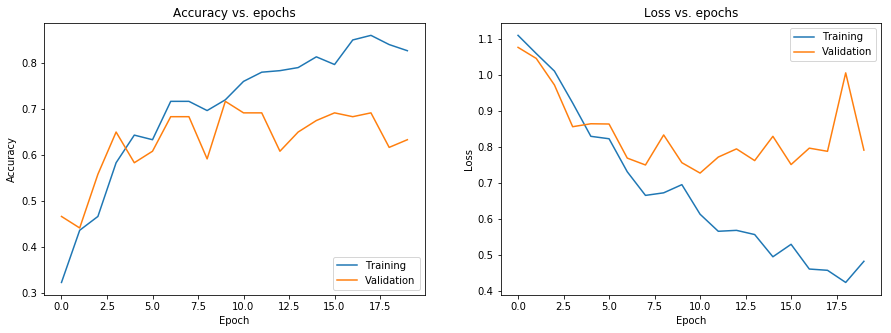

In [20]:
# Run this cell to plot accuracy vs epoch and loss vs epoch

plt.figure(figsize=(15,5))
plt.subplot(121)
try:
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
except KeyError:
    try:
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
    except KeyError:
        plt.plot(history.history['categorical_accuracy'])
        plt.plot(history.history['val_categorical_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')

plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show() 

You may notice overfitting in the above plots, through a growing discrepancy between the training and validation loss and accuracy. We will aim to mitigate this using data augmentation. Given our limited dataset, we may be able to improve the performance by applying random modifications to the images in the training data, effectively increasing the size of the dataset.

#### Create a new data generator with data augmentation

You should now write a function to create a new `ImageDataGenerator` object, which performs the following data preprocessing and augmentation:

* Scales the image pixel values by a factor of 1/255.
* Randomly rotates images by up to 30 degrees
* Randomly alters the brightness (picks a brightness shift value) from the range (0.5, 1.5)
* Randomly flips images horizontally

Hint: you may need to refer to the [documentation](https://keras.io/preprocessing/image/#imagedatagenerator-class) for the `ImageDataGenerator`.

In [21]:
#### GRADED CELL ####

# Complete the following function. 
# Make sure to not change the function name or arguments.

def get_ImageDataGenerator_augmented():
    """
    This function should return an instance of the ImageDataGenerator class 
    with the above specifications.
    """
    return ImageDataGenerator(rescale=1/255., 
                             rotation_range=30,
                             brightness_range=(0.5, 1.5),
                             horizontal_flip = True)
    

In [22]:
# Call the function to get an ImageDataGenerator as specified

image_gen_aug = get_ImageDataGenerator_augmented()

In [23]:
# Run this cell to define training and validation generators 

valid_generator_aug = get_generator(image_gen_aug, valid_dir)
train_generator_aug = get_generator(image_gen_aug, train_dir, seed=10)

Found 120 images belonging to 3 classes.
Found 300 images belonging to 3 classes.


In [24]:
# Reset the original train_generator with the same random seed

train_generator = get_generator(image_gen, train_dir, seed=10)

Found 300 images belonging to 3 classes.


#### Display sample augmented images and labels from the training set

The following cell depends on your function `get_generator` to be implemented correctly. If it raises an error, go back and check the function specifications carefully. 

The cell will display augmented and non-augmented images (and labels) from the training dataset, using the `train_generator_aug` and `train_generator` objects defined above (if the images do not correspond to each other, check you have implemented the `seed` argument correctly).

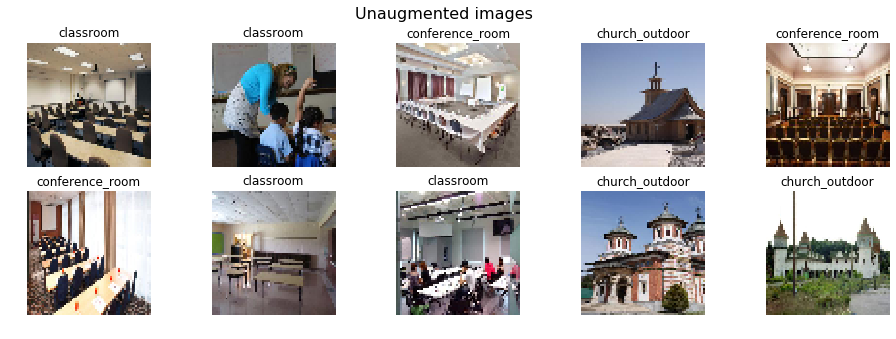

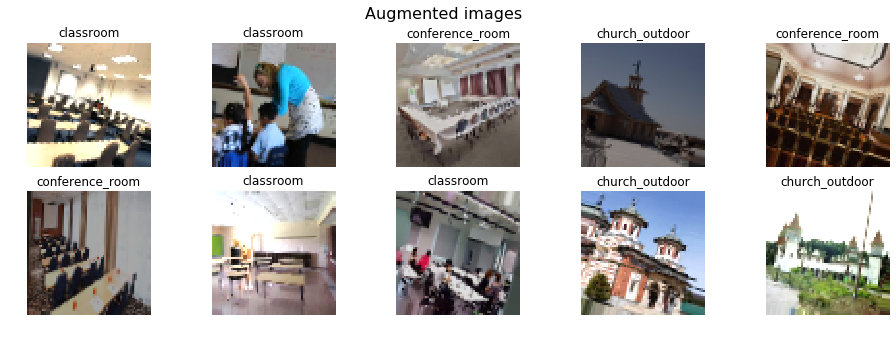

In [25]:
# Display a few images and labels from the non-augmented and augmented generators

batch = next(train_generator)
batch_images = np.array(batch[0])
batch_labels = np.array(batch[1])

aug_batch = next(train_generator_aug)
aug_batch_images = np.array(aug_batch[0])
aug_batch_labels = np.array(aug_batch[1])

plt.figure(figsize=(16,5))
plt.suptitle("Unaugmented images", fontsize=16)
for n, i in enumerate(np.arange(10)):
    ax = plt.subplot(2, 5, n+1)
    plt.imshow(batch_images[i])
    plt.title(lsun_classes[np.where(batch_labels[i] == 1.)[0][0]])
    plt.axis('off')
plt.figure(figsize=(16,5))
plt.suptitle("Augmented images", fontsize=16)
for n, i in enumerate(np.arange(10)):
    ax = plt.subplot(2, 5, n+1)
    plt.imshow(aug_batch_images[i])
    plt.title(lsun_classes[np.where(aug_batch_labels[i] == 1.)[0][0]])
    plt.axis('off')

In [26]:
# Reset the augmented data generator

train_generator_aug = get_generator(image_gen_aug, train_dir)

Found 300 images belonging to 3 classes.


#### Train a new model on the augmented dataset

In [27]:
# Build and compile a new model

lsun_new_model = get_model((64, 64, 3))

In [28]:
# Train the model

history_augmented = train_model(lsun_new_model, train_generator_aug, valid_generator_aug, epochs=50)

Train for 15 steps, validate for 6 steps
Epoch 1/50
15/15 [==============================] - 11s 706ms/step - loss: 1.1020 - accuracy: 0.3267 - val_loss: 1.0863 - val_accuracy: 0.3833
Epoch 2/50
15/15 [==============================] - 10s 640ms/step - loss: 1.0809 - accuracy: 0.4433 - val_loss: 1.0686 - val_accuracy: 0.4917
Epoch 3/50
15/15 [==============================] - 10s 647ms/step - loss: 1.0611 - accuracy: 0.4933 - val_loss: 1.0353 - val_accuracy: 0.5083
Epoch 4/50
15/15 [==============================] - 10s 647ms/step - loss: 1.0110 - accuracy: 0.4600 - val_loss: 0.9840 - val_accuracy: 0.5000
Epoch 5/50
15/15 [==============================] - 10s 647ms/step - loss: 0.9597 - accuracy: 0.5633 - val_loss: 0.9075 - val_accuracy: 0.5750
Epoch 6/50
15/15 [==============================] - 9s 633ms/step - loss: 0.8936 - accuracy: 0.5667 - val_loss: 0.8805 - val_accuracy: 0.6417
Epoch 7/50
15/15 [==============================] - 9s 627ms/step - loss: 0.8381 - accuracy: 0.6167 - 

#### Plot the learning curves

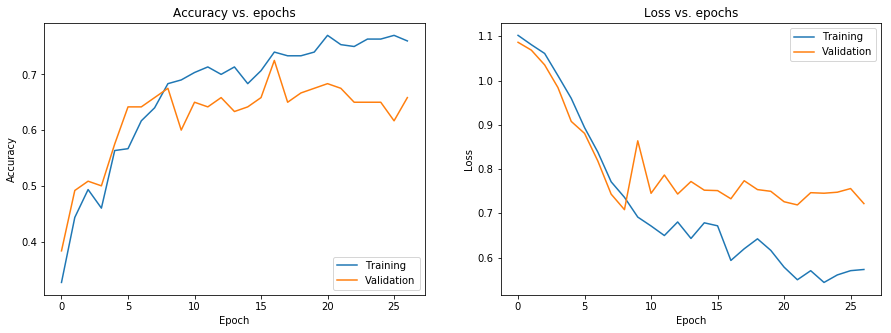

In [29]:
# Run this cell to plot accuracy vs epoch and loss vs epoch

plt.figure(figsize=(15,5))
plt.subplot(121)
try:
    plt.plot(history_augmented.history['accuracy'])
    plt.plot(history_augmented.history['val_accuracy'])
except KeyError:
    try:
        plt.plot(history_augmented.history['acc'])
        plt.plot(history_augmented.history['val_acc'])
    except KeyError:
        plt.plot(history_augmented.history['categorical_accuracy'])
        plt.plot(history_augmented.history['val_categorical_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')

plt.subplot(122)
plt.plot(history_augmented.history['loss'])
plt.plot(history_augmented.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show() 

Do you see an improvement in the overfitting? This will of course vary based on your particular run and whether you have altered the hyperparameters.

#### Get predictions using the trained model

In [30]:
# Get model predictions for the first 3 batches of test data

num_batches = 3
seed = 25
test_generator = get_generator(image_gen_aug, test_dir, seed=seed)
predictions = lsun_new_model.predict_generator(test_generator, steps=num_batches)

Found 300 images belonging to 3 classes.


Found 300 images belonging to 3 classes.
[26 14 27 55]


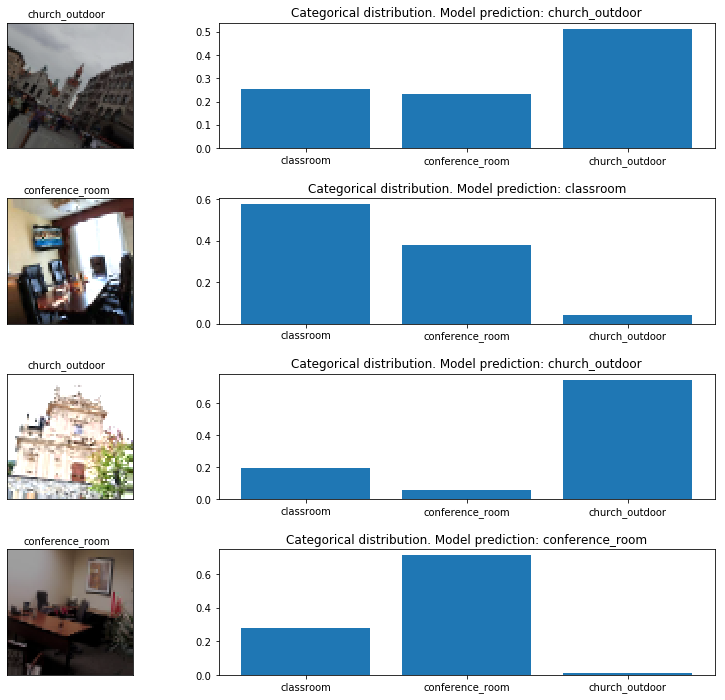

In [31]:
# Run this cell to view randomly selected images and model predictions

# Get images and ground truth labels
test_generator = get_generator(image_gen_aug, test_dir, seed=seed)
batches = []
for i in range(num_batches):
    batches.append(next(test_generator))
    
batch_images = np.vstack([b[0] for b in batches])
batch_labels = np.concatenate([b[1].astype(np.int32) for b in batches])

# Randomly select images from the batch
inx = np.random.choice(predictions.shape[0], 4, replace=False)
print(inx)

fig, axes = plt.subplots(4, 2, figsize=(16, 12))
fig.subplots_adjust(hspace=0.4, wspace=-0.2)

for n, i in enumerate(inx):
    axes[n, 0].imshow(batch_images[i])
    axes[n, 0].get_xaxis().set_visible(False)
    axes[n, 0].get_yaxis().set_visible(False)
    axes[n, 0].text(30., -3.5, lsun_classes[np.where(batch_labels[i] == 1.)[0][0]], 
                    horizontalalignment='center')
    axes[n, 1].bar(np.arange(len(predictions[i])), predictions[i])
    axes[n, 1].set_xticks(np.arange(len(predictions[i])))
    axes[n, 1].set_xticklabels(lsun_classes)
    axes[n, 1].set_title(f"Categorical distribution. Model prediction: {lsun_classes[np.argmax(predictions[i])]}")
    
plt.show()

Congratulations! This completes the first part of the programming assignment using the tf.keras image data processing tools.

### Part 2: tf.data

![CIFAR-100 overview image](data/cifar100/cifar100.png)

#### The CIFAR-100 Dataset

In the second part of this assignment, you will use the [CIFAR-100 dataset](https://www.cs.toronto.edu/~kriz/cifar.html). This image dataset has 100 classes with 500 training images and 100 test images per class. 

* A. Krizhevsky. "Learning Multiple Layers of Features from Tiny Images". April 2009 

Your goal is to use the tf.data module preprocessing tools to construct a data ingestion pipeline including filtering and function mapping over the dataset to train a neural network to classify the images.

#### Load the dataset

In [32]:
# Load the data, along with the labels

(train_data, train_labels), (test_data, test_labels) = cifar100.load_data(label_mode='fine')
with open('data/cifar100/cifar100_labels.json', 'r') as j:
    cifar_labels = json.load(j)

169009152/169001437 [==============================] - 2s 0us/step


#### Display sample images and labels from the training set

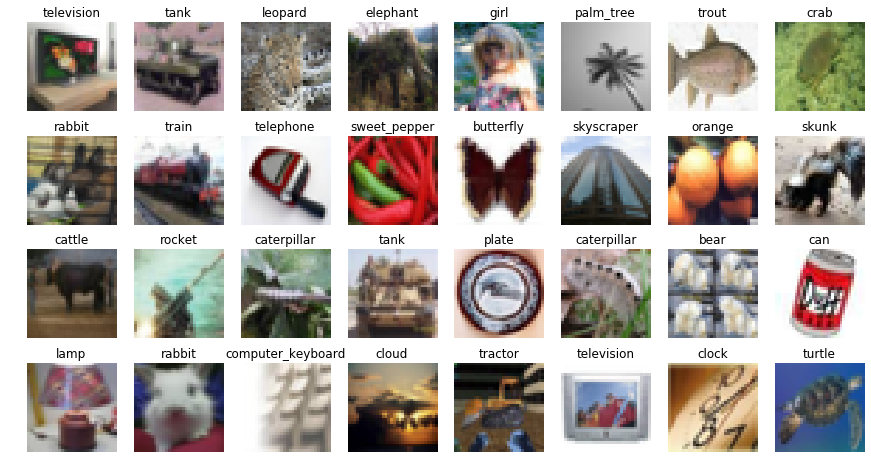

In [33]:
# Display a few images and labels

plt.figure(figsize=(15,8))
inx = np.random.choice(train_data.shape[0], 32, replace=False)
for n, i in enumerate(inx):
    ax = plt.subplot(4, 8, n+1)
    plt.imshow(train_data[i])
    plt.title(cifar_labels[int(train_labels[i])])
    plt.axis('off')

#### Create Dataset objects for the train and test images

You should now write a function to create a `tf.data.Dataset` object for each of the training and test images and labels. This function should take a numpy array of images in the first argument and a numpy array of labels in the second argument, and create a `Dataset` object. 

Your function should then return the `Dataset` object. Do not batch or shuffle the `Dataset` (this will be done later).

In [34]:
#### GRADED CELL ####

# Complete the following function. 
# Make sure to not change the function name or arguments.

def create_dataset(data, labels):
    """
    This function takes a numpy array batch of images in the first argument, and
    a corresponding array containing the labels in the second argument.
    The function should then create a tf.data.Dataset object with these inputs
    and outputs, and return it.
    """
    cdata = tf.data.Dataset.from_tensor_slices(data)
    clabels = tf.data.Dataset.from_tensor_slices(labels)
    return tf.data.Dataset.zip((cdata, clabels))
    

In [35]:
# Run the below cell to convert the training and test data and labels into datasets

train_dataset = create_dataset(train_data, train_labels)
test_dataset = create_dataset(test_data, test_labels)

In [36]:
# Check the element_spec of your datasets

print(train_dataset.element_spec)
print(test_dataset.element_spec)

(TensorSpec(shape=(32, 32, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(1,), dtype=tf.int64, name=None))
(TensorSpec(shape=(32, 32, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(1,), dtype=tf.int64, name=None))


#### Filter the Dataset

Write a function to filter the train and test datasets so that they only generate images that belong to a specified set of classes. 

The function should take a `Dataset` object in the first argument, and a list of integer class indices in the second argument. Inside your function you should define an auxiliary function that you will use with the `filter` method of the `Dataset` object. This auxiliary function should take image and label arguments (as in the `element_spec`) for a single element in the batch, and return a boolean indicating if the label is one of the allowed classes. 

Your function should then return the filtered dataset.

**Hint:** you may need to use the [`tf.equal`](https://www.tensorflow.org/api_docs/python/tf/math/equal), [`tf.cast`](https://www.tensorflow.org/api_docs/python/tf/dtypes/cast) and [`tf.math.reduce_any`](https://www.tensorflow.org/api_docs/python/tf/math/reduce_any) functions in your auxiliary function. 

In [37]:
#### GRADED CELL ####

# Complete the following function. 
# Make sure to not change the function name or arguments.

def filter_classes(dataset, classes):
    """
    This function should filter the dataset by only retaining dataset elements whose
    label belongs to one of the integers in the classes list.
    The function should then return the filtered Dataset object.
    """
    def filter_classes(data, label):
        return tf.math.reduce_any(tf.equal(label, classes))
    return dataset.filter(filter_classes)
    

In [38]:
# Run the below cell to filter the datasets using your function

cifar_classes = [0, 29, 99] # Your datasets should contain only classes in this list

train_dataset = filter_classes(train_dataset, cifar_classes)
test_dataset = filter_classes(test_dataset, cifar_classes)

#### Apply map functions to the Dataset

You should now write two functions that use the `map` method to process the images and labels in the filtered dataset. 

The first function should one-hot encode the remaining labels so that we can train the network using a categorical cross entropy loss. 

The function should take a `Dataset` object as an argument. Inside your function you should define an auxiliary function that you will use with the `map` method of the `Dataset` object. This auxiliary function should take image and label arguments (as in the `element_spec`) for a single element in the batch, and return a tuple of two elements, with the unmodified image in the first element, and a one-hot vector in the second element. The labels should be encoded according to the following:

* Class 0 maps to `[1., 0., 0.]`
* Class 29 maps to `[0., 1., 0.]`
* Class 99 maps to `[0., 0., 1.]`

Your function should then return the mapped dataset.

In [39]:
#### GRADED CELL ####

# Complete the following function. 
# Make sure to not change the function name or arguments.

def map_labels(dataset):
    """
    This function should map over the dataset to convert the label to a 
    one-hot vector. The encoding should be done according to the above specification.
    The function should then return the mapped Dataset object.
    """
    def one_hot(image, label): 
        if tf.equal(label, 0): 
            label = [1., 0., 0.] 
        elif tf.equal(label, 29): 
            label = [0., 1., 0.] 
        else: 
            label = [0., 0., 1.]
        return image, label 

    return dataset.map(one_hot)
    

In [40]:
# Run the below cell to one-hot encode the training and test labels.

train_dataset = map_labels(train_dataset)
test_dataset = map_labels(test_dataset)

The second function should process the images according to the following specification:

* Rescale the image pixel values by a factor of 1/255.
* Convert the colour images (3 channels) to black and white images (single channel) by computing the average pixel value across all channels. 

The function should take a `Dataset` object as an argument. Inside your function you should again define an auxiliary function that you will use with the `map` method of the `Dataset` object. This auxiliary function should take image and label arguments (as in the `element_spec`) for a single element in the batch, and return a tuple of two elements, with the processed image in the first element, and the unmodified label in the second argument.

Your function should then return the mapped dataset.

**Hint:** you may find it useful to use [`tf.reduce_mean`](https://www.tensorflow.org/api_docs/python/tf/math/reduce_mean?version=stable) since the black and white image is the colour-average of the colour images. You can also use the `keepdims` keyword in `tf.reduce_mean` to retain the single colour channel.

In [41]:
#### GRADED CELL ####

# Complete the following function. 
# Make sure to not change the function name or arguments.

def map_images(dataset):
    """
    This function should map over the dataset to process the image according to the 
    above specification. The function should then return the mapped Dataset object.
    """
    def map_func(image, label):
        image = image / 255
        image = tf.reduce_mean(image, axis=-1, keepdims=True)
        return image, label

    return dataset.map(map_func)
    

In [42]:
# Run the below cell to apply your mapping function to the datasets

train_dataset_bw = map_images(train_dataset)
test_dataset_bw = map_images(test_dataset)

#### Display a batch of processed images

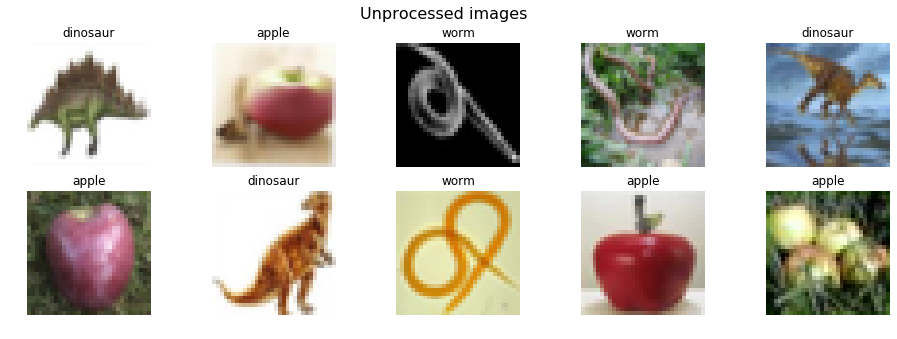

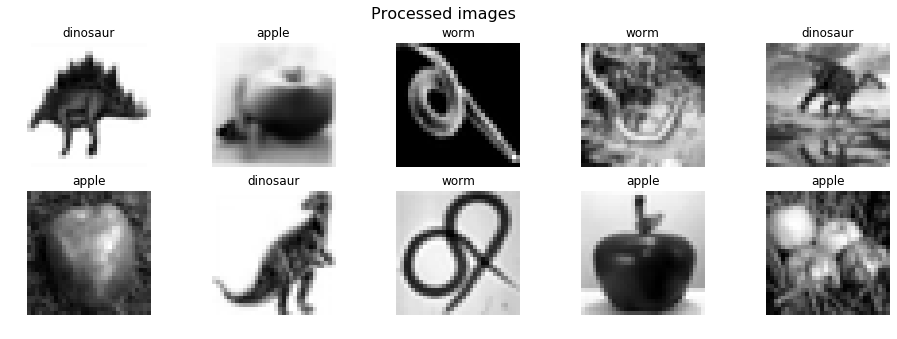

In [43]:
# Run this cell to view a selection of images before and after processing

plt.figure(figsize=(16,5))
plt.suptitle("Unprocessed images", fontsize=16)
for n, elem in enumerate(train_dataset.take(10)):
    images, labels = elem
    ax = plt.subplot(2, 5, n+1)
    plt.title(cifar_labels[cifar_classes[np.where(labels == 1.)[0][0]]])
    plt.imshow(np.squeeze(images), cmap='gray')
    plt.axis('off')
    
plt.figure(figsize=(16,5))
plt.suptitle("Processed images", fontsize=16)
for n, elem in enumerate(train_dataset_bw.take(10)):
    images_bw, labels_bw = elem
    ax = plt.subplot(2, 5, n+1)
    plt.title(cifar_labels[cifar_classes[np.where(labels_bw == 1.)[0][0]]])
    plt.imshow(np.squeeze(images_bw), cmap='gray')
    plt.axis('off')

We will now batch and shuffle the Dataset objects.

In [44]:
# Run the below cell to batch the training dataset and expand the final dimensinos

train_dataset_bw = train_dataset_bw.batch(10)
train_dataset_bw = train_dataset_bw.shuffle(100)

test_dataset_bw = test_dataset_bw.batch(10)
test_dataset_bw = test_dataset_bw.shuffle(100)

#### Train a neural network model

Now we will train a model using the `Dataset` objects. We will use the model specification and function from the first part of this assignment, only modifying the size of the input images.

In [45]:
# Build and compile a new model with our original spec, using the new image size
    
cifar_model = get_model((32, 32, 1))

In [46]:
# Train the model for 15 epochs

history = cifar_model.fit(train_dataset_bw, validation_data=test_dataset_bw, epochs=15)

Epoch 1/15
150/150 [==============================] - 21s 142ms/step - loss: 1.0771 - accuracy: 0.4047 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/15
150/150 [==============================] - 20s 131ms/step - loss: 0.9885 - accuracy: 0.5540 - val_loss: 0.8698 - val_accuracy: 0.6367
Epoch 3/15
150/150 [==============================] - 20s 131ms/step - loss: 0.8509 - accuracy: 0.6340 - val_loss: 0.8084 - val_accuracy: 0.6500
Epoch 4/15
150/150 [==============================] - 20s 133ms/step - loss: 0.7829 - accuracy: 0.6627 - val_loss: 0.7606 - val_accuracy: 0.6900
Epoch 5/15
150/150 [==============================] - 20s 135ms/step - loss: 0.7394 - accuracy: 0.7000 - val_loss: 0.7375 - val_accuracy: 0.6900
Epoch 6/15
150/150 [==============================] - 20s 131ms/step - loss: 0.7032 - accuracy: 0.7073 - val_loss: 0.6911 - val_accuracy: 0.7333
Epoch 7/15
150/150 [==============================] - 19s 130ms/step - loss: 0.6594 - accuracy: 0.7340 - val_loss: 0.6425 

#### Plot the learning curves

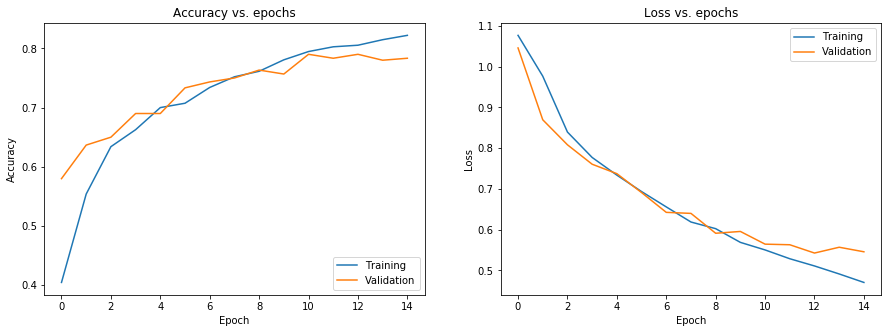

In [47]:
# Run this cell to plot accuracy vs epoch and loss vs epoch

plt.figure(figsize=(15,5))
plt.subplot(121)
try:
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
except KeyError:
    try:
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
    except KeyError:
        plt.plot(history.history['categorical_accuracy'])
        plt.plot(history.history['val_categorical_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')

plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show() 

In [48]:
# Create an iterable from the batched test dataset

test_dataset = test_dataset.batch(10)
iter_test_dataset = iter(test_dataset)

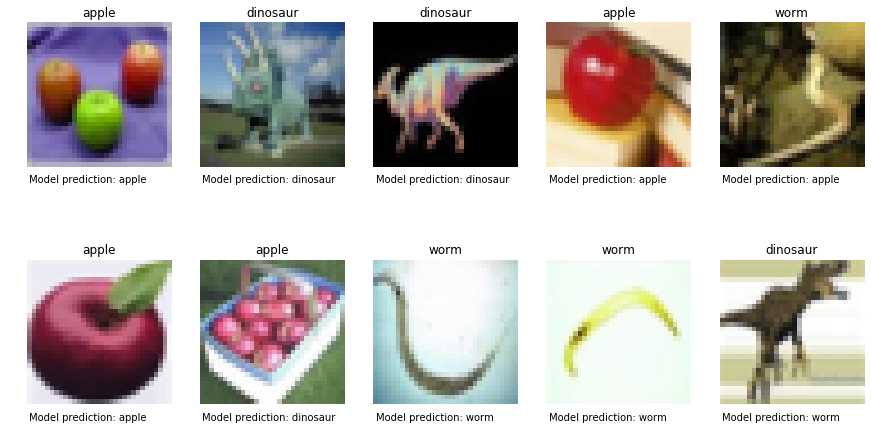

In [49]:
# Display model predictions for a sample of test images

plt.figure(figsize=(15,8))
inx = np.random.choice(test_data.shape[0], 18, replace=False)
images, labels = next(iter_test_dataset)
probs = cifar_model(tf.reduce_mean(tf.cast(images, tf.float32), axis=-1, keepdims=True) / 255.)
preds = np.argmax(probs, axis=1)
for n in range(10):
    ax = plt.subplot(2, 5, n+1)
    plt.imshow(images[n])
    plt.title(cifar_labels[cifar_classes[np.where(labels[n].numpy() == 1.0)[0][0]]])
    plt.text(0, 35, "Model prediction: {}".format(cifar_labels[cifar_classes[preds[n]]]))
    plt.axis('off')

Congratulations for completing this programming assignment! In the next week of the course we will learn to develop models for sequential data.